In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp
import scipy
import scipy.interpolate

EOS Classes

In [ ]:
class EOS():
    def __init__(self):
        """
        Base class for Equation of State (EOS).

        This class provides a template for defining different EOS subclasses.
        """
        print("Setting up base class EOS")

    def P(self, e, rho):
        """
        Placeholder method for pressure calculation.

        Parameters:
        - e (float): Internal energy per unit mass.
        - rho (float): Density.

        Returns:
        float: Pressure.
        """
        pass


class Dust(EOS):
    """
    Equation of State subclass for dust.

    This class inherits from the base EOS class and implements specific methods
    for a dust equation of state.
    """
    def __init__(self):
        """
        Initialize Dust EOS.

        This method sets up the Dust-Law EOS and calls the base class constructor.
        """
        EOS.__init__(self)
        print("Setting up Dust-Law EOS")

    def P(self, e, rho):
        """
        Pressure calculation method for dust.

        Parameters:
        - e (float): Internal energy per unit mass.
        - rho (float): Density.

        Returns:
        float: Pressure (always 0.0 for dust).
        """
        return 0.0

    def P_cold(self, rho):
        """
        Cold pressure calculation method for dust.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Cold pressure (always 0.0 for dust).
        """
        return 0.0

    def e_cold(self, rho):
        """
        Cold internal energy calculation method for dust.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Cold internal energy (always 0.0 for dust).
        """
        return 0.0

    def rho(self, P):
        """
        Density calculation method for dust.

        Parameters:
        - P (float): Pressure.

        Returns:
        None: Placeholder method for density calculation (not implemented for dust).
        """
        pass

    def name(self):
        """
        Get the name of the EOS.

        Returns:
        str: Name of the Dust EOS.
        """
        print("Dust EOS")
        return "Dust EOS"


class GammaLaw(EOS):
    """
    Equation of State subclass for gamma law gas.

    This class inherits from the base EOS class and implements specific methods
    for a gamma law gas equation of state.
    """
    def __init__(self, K, Gamma):
        """
        Initialize GammaLaw EOS.

        Parameters:
        - K (float): Bulk modulus.
        - Gamma (float): Heat capacity ratio.

        This method sets up the Gamma-Law EOS, calls the base class constructor,
        and initializes the bulk modulus (K) and heat capacity ratio (Gamma).
        """
        EOS.__init__(self)
        print("Setting up Gamma-Law EOS with K =", K, "and Gamma =", Gamma)
        self.K = K
        self.Gamma = Gamma

    def P(self, e, rho):
        """
        Pressure calculation method for gamma law gas.

        Parameters:
        - e (float): Internal energy per unit mass.
        - rho (float): Density.

        Returns:
        float: Pressure.
        """
        return (self.Gamma - 1.0) * e * rho

    def P_cold(self, rho):
        """
        Cold pressure calculation method for gamma law gas.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Cold pressure.
        """
        return self.K * (rho ** self.Gamma)

    def e_cold(self, rho):
        """
        Cold internal energy calculation method for gamma law gas.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Cold internal energy.
        """
        return self.P_cold(rho) / ((self.Gamma - 1) * rho)

    def rho(self, P):
        """
        Density calculation method for gamma law gas.

        Parameters:
        - P (float): Pressure.

        Returns:
        float: Density.
        """
        return (P / self.K) ** (1 / self.Gamma)

    def soundSpeed(self, rho):
        """
        Sound speed calculation method for gamma law gas.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Sound speed.
        """
        return np.sqrt(self.K * self.Gamma * (rho ** (self.Gamma - 1)))

    def reset_gamma0(self, gamma0):
        """
        Reset the heat capacity ratio (Gamma).

        Parameters:
        - gamma0 (float): New heat capacity ratio.

        This method allows changing the heat capacity ratio (Gamma) dynamically.
        """
        self.Gamma = gamma0

    def name(self):
        """
        Get the name of the EOS.

        Returns:
        str: Name of the GammaLaw EOS.
        """
        print("GammaLaw EOS")
        return "GammaLaw EOS"


class PiecewisePolytropic(EOS):
    """
    Equation of State subclass for polytropic fluid.

    This class inherits from the base EOS class and implements specific methods
    for a piecewise polytropic equation of state.
    """
    def __init__(self, rho_nucl, gamma1, gamma0):
        """
        Initialize PiecewisePolytropic EOS.

        Parameters:
        - rho_nucl (float): Nuclear density threshold.
        - gamma1 (float): Heat capacity ratio for high-density regime.
        - gamma0 (float): Heat capacity ratio for low-density regime.

        This method sets up the piecewise polytropic EOS, calls the base class constructor,
        and initializes parameters such as nuclear density threshold (rho_nucl),
        heat capacity ratio for high-density regime (gamma1),
        and heat capacity ratio for low-density regime (gamma0).
        It also calculates and sets auxiliary parameters k0, k1, and b1.
        """
        EOS.__init__(self)
        print("Setting up piecewise polytropic EOS")
        self.rho_nucl = rho_nucl
        self.gamma1 = gamma1
        self.gamma0 = gamma0
        self.k0 = 61382  # Derived in problem 10.2a
        self.k1 = 0
        self.b1 = 0
        self.set_k1()
        self.set_b1()

    def set_k1(self):
        """
        Calculate and set the k1 parameter.

        This method calculates the k1 parameter based on k0, rho_nucl, gamma0, and gamma1.
        """
        self.k1 = self.k0 * (self.rho_nucl ** (self.gamma0 - self.gamma1))

    def set_b1(self):
        """
        Calculate and set the b1 parameter.

        This method calculates the b1 parameter based on k0, rho_nucl, gamma0, and gamma1.
        """
        first_term = self.k0 * (self.rho_nucl ** (self.gamma0 - 1))
        sec_term = (1 / (self.gamma0 - 1)) - (1 / (self.gamma1 - 1))
        self.b1 = first_term * sec_term

    def reset_gamma0(self, gamma0):
        """
        Reset the heat capacity ratio (gamma0).

        Parameters:
        - gamma0 (float): New heat capacity ratio for low-density regime.

        This method allows changing the heat capacity ratio (gamma0) dynamically
        and recalculates dependent parameters k1 and b1.
        """
        print("Resetting gamma0")
        self.gamma0 = gamma0
        self.set_k1()
        self.set_b1()

    def P(self, e, rho):
        """
        Pressure calculation method for piecewise polytropic fluid.

        Parameters:
        - e (float): Internal energy per unit mass.
        - rho (float): Density.

        Returns:
        float: Pressure.
        """
        eth = e - self.e_cold(rho)
        Pth = eth * rho / 3
        Pcold = self.P_cold(rho)
        return Pcold + Pth

    def P_cold(self, rho):
        """
        Cold pressure calculation method for piecewise polytropic fluid.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Cold pressure.
        """
        if rho <= self.rho_nucl:
            k = self.k0
            gamma = self.gamma0
        else:
            gamma = self.gamma1
            k = self.k1
        return k * (rho ** gamma)

    def e_cold(self, rho):
        """
        Cold internal energy calculation method for piecewise polytropic fluid.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Cold internal energy.
        """
        if rho <= self.rho_nucl:
            k = self.k0
            gamma = self.gamma0
            b = 0
        else:
            gamma = self.gamma1
            k = self.k1
            b = self.b1
        return (k / (gamma - 1)) * (rho ** (gamma - 1)) + b

    def rho(self, P):
        """
        Density calculation method for piecewise polytropic fluid.

        Parameters:
        - P (float): Pressure.

        Returns:
        float: Density.
        """
        Pnucl = self.P_cold(self.rho_nucl)
        if P <= Pnucl:
            k = self.k0
            gamma = self.gamma0
        else:
            gamma = self.gamma1
            k = self.k1
        return (P / k) ** (1 / gamma)

    def soundSpeed(self, rho):
        """
        Sound speed calculation method for piecewise polytropic fluid.

        Parameters:
        - rho (float): Density.

        Returns:
        float: Sound speed.
        """
        if rho <= self.rho_nucl:
            k = self.k0
            gamma = self.gamma0
        else:
            gamma = self.gamma1
            k = self.k1
        return np.sqrt(k * gamma * (rho ** (gamma - 1)))

    def name(self):
        """
        Get the name of the EOS.

        Returns:
        str: Name of the Piecewise Polytopic EOS.
        """
        print("Piecewise Polytopic EOS")
        return "Piecewise Polytopic EOS"


Initial Data Class

In [ ]:
class InitialData:
    def __init__(self):
        """
        Base class for initializing gridpoints of initial data.

        This class provides a template for defining different initial data models.
        """
        print("Creating InitialData Object with", self.n, "gridpoints")


class constantDensityModel(InitialData):
    """
    Initial data gridpoints for dust.

    This class inherits from the base InitialData class and implements a constant density model.
    """
    def __init__(self, R, M, n):
        """
        Initialize constantDensityModel.

        Parameters:
        - R (float): Radius of the object.
        - M (float): Total mass of the object.
        - n (int): Number of gridpoints.

        This method initializes the constant density model with specified parameters.
        """
        self.R = R
        self.M = M
        self.n = n

    def initialize_data(self):
        """
        Initialize data for the constant density model.

        Returns:
        list: Lists containing mass (m) and radius (r) gridpoints.
        """
        delta_m = self.M / self.n
        rho = self.M / ((4/3) * np.pi * (self.R ** 3))
        m = np.zeros(self.n)
        r = np.zeros(self.n)
        for i in range(self.n):
            m[i] = (i + 1) * delta_m
            r[i] = (m[i] / ((4/3) * np.pi * rho)) ** (1/3)
        return [m, r]


class equilibriumModel(InitialData):
    """
    Initial data gridpoints for non-dust.

    This class inherits from the base InitialData class and implements an equilibrium model.
    """
    def __init__(self, EOS, rho_c, n, R_est):
        """
        Initialize equilibriumModel.

        Parameters:
        - EOS: Equation of State object.
        - rho_c (float): Central density.
        - n (int): Number of gridpoints.
        - R_est (float): Estimated radius.

        This method initializes the equilibrium model with specified parameters.
        """
        self.EOS = EOS
        self.rho_c = rho_c
        self.n = n
        self.R_est = R_est

    def zero_crossing(self, r, vect):
        """
        Zero-crossing function for solver event.

        Parameters:
        - r (float): Radial coordinate.
        - vect (list): Vector containing pressure (p) and mass (m).

        Returns:
        float: Value of the zero-crossing function.
        """
        return vect[0]

    def equil_sols(self, r, vect):
        """
        Equilibrium solutions for the equilibrium model.

        Parameters:
        - r (float): Radial coordinate.
        - vect (list): Vector containing pressure (p) and mass (m).

        Returns:
        tuple: Tuple containing derivatives dp/dr and dm/dr.
        """
        G = 132733
        p = vect[0]
        m = vect[1]

        rho = self.EOS.rho(p)

        if r == 0:
            dpdr = 0
        else:
            dpdr = (- rho * G * m) / (r ** 2)

        dmdr = 4 * np.pi * (r ** 2) * rho
        return dpdr, dmdr

    def solve_star(self, R, rho_c):
        """
        Solve the equilibrium model up to the stellar surface.

        Parameters:
        - R (float): Estimated radius.
        - rho_c (float): Central density.

        Returns:
        tuple: Tuple containing radial coordinates, pressure, and mass.
        """
        P_c = self.EOS.P_cold(rho_c)

        m_o = 0
        init_vect = [P_c, m_o]

        equilibriumModel.zero_crossing.terminal = True
        tol = 1.e-8
        r = np.linspace(0.001, R, 1000)

        sol = solve_ivp(self.equil_sols, [0.0, R], init_vect, t_eval=r,
                        atol=tol, rtol=tol, events=self.zero_crossing)

        # Check to make sure hard-coded R is reasonable
        new_R = sol.t[-1]
        P = sol.y[0][-1]
        if abs(P - 0) > 1e-5:
            raise ValueError("P does not equal 0 at the surface: R estimate too small")
        elif (self.R_est - new_R) > 2:
            raise ValueError("Estimate for R is much larger than actual R (going to waste gridpoints)")

        return sol.t, sol.y[0], sol.y[1]

    def interpolate(self, n, R, rho_c):
        """
        Interpolate gridpoints for the equilibrium model.

        Parameters:
        - n (int): Number of gridpoints.
        - R (float): Estimated radius.
        - rho_c (float): Central density.

        Returns:
        list: Lists containing mass (m) and radius (r) gridpoints.
        """
        m_ints = np.zeros(n)

        r, p, m = self.solve_star(R, rho_c)
        r_of_m = scipy.interpolate.interp1d(m, r)

        M = max(m)

        delta_m = M / n
        r_ints = np.zeros(n)
        for i in range(n):
            curr_m_int = (i + 1) * delta_m
            m_ints[i] = curr_m_int
            r_ints[i] = r_of_m(curr_m_int)

        return [m_ints, r_ints]

    def initialize_data(self):
        """
        Initialize data for the equilibrium model.

        Returns:
        list: Lists containing mass (m) and radius (r) gridpoints.
        """
        m, r = self.interpolate(self.n, self.R_est, self.rho_c)
        return [m, r]

GridFunction Class

In [ ]:
class GridFunction:
    def __init__(self, m, name):
        """
        Initialize a GridFunction object.

        Parameters:
        - m (numpy array): Grid points.
        - name (str): Name of the GridFunction.

        This method initializes a GridFunction object with specified grid points and a name.
        """
        self.m = m
        self.name = name
        self.delta = m[1] - m[0]
        self.n = np.size(m)
        self.data = np.zeros(self.n)
        self.deriv = np.zeros(self.n)

    def __getitem__(self, index):
        """
        Get the value at the specified index.

        Parameters:
        - index (int): Index to retrieve the value.

        Returns:
        float: Value at the specified index.
        """
        return self.data[index]

    def __setitem__(self, index, value):
        """
        Set the value at the specified index.

        Parameters:
        - index (int): Index to set the value.
        - value (float): Value to set at the specified index.
        """
        self.data[index] = value

    def equals_const(self, value):
        """
        Set all values of the GridFunction to a constant value.

        Parameters:
        - value (float): Constant value to set for all elements of the GridFunction.
        """
        for i in range(self.n):
            self.data[i] = value

    def equals(self, gf):
        """
        Set the data of the GridFunction to match another GridFunction.

        Parameters:
        - gf (GridFunction): Another GridFunction object to match the data with.
        """
        for i in range(self.n):
            self.data[i] = gf.data[i]

    def plus(self, factor, gf):
        """
        Add the data of another GridFunction multiplied by a factor.

        Parameters:
        - factor (float): Multiplication factor.
        - gf (GridFunction): Another GridFunction object to add to the current GridFunction.
        """
        for i in range(self.n):
            self.data[i] += factor * gf.data[i]

    def plot(self):
        """
        Plot the data of the GridFunction over the grid points (m).
        """
        plt.plot(self.m, self.data)
        plt.xlabel("m", size=14)
        plt.ylabel(self.name, size=14)
        plt.show()


class VertexCentered(GridFunction):
    def dm(self):
        """
        Calculate and return the first derivative of the data with respect to m (dm/dm) for vertex-centered GridFunction.

        Returns:
        numpy array: First derivative of the data with respect to m.
        """
        for i in range(1, self.n):
            self.deriv[i] = (self.data[i] - self.data[i - 1]) / self.delta
        # Implement boundary conditions
        self.deriv[0] = self.data[0] / self.delta
        return self.deriv


class CellCentered(GridFunction):
    def dm(self):
        """
        Calculate and return the first derivative of the data with respect to m (dm/dm) for cell-centered GridFunction.

        Returns:
        numpy array: First derivative of the data with respect to m.
        """
        for i in range(self.n - 1):
            self.deriv[i] = (self.data[i + 1] - self.data[i]) / self.delta
        # Implement boundary conditions
        self.deriv[self.n - 1] = -2 * self.data[self.n - 1] / self.delta
        return self.deriv

State Class

In [ ]:
class State:
    def __init__(self, m, name):
        """
        Initialize a State object.

        Parameters:
        - m (numpy array): Grid points.
        - name (str): Name of the State.

        This method initializes a State object with specified grid points and a name.
        Creates vertex-centered and cell-centered grid functions for velocity (u),
        radius (r), density (rho), and internal energy (e).
        """
        self.m = m
        self.name = name

        self.u = VertexCentered(m, "U")
        self.r = VertexCentered(m, "r")
        self.rho = CellCentered(m, "rho")
        self.e = CellCentered(m, "e")

    def equals(self, state):
        """
        Set the data of the State to match another State.

        Parameters:
        - state (State): Another State object to match the data with.
        """
        self.u.equals(state.u)
        self.r.equals(state.r)
        self.rho.equals(state.rho)
        self.e.equals(state.e)

    def plus(self, factor, state):
        """
        Add the data of another State multiplied by a factor.

        Parameters:
        - factor (float): Multiplication factor.
        - state (State): Another State object to add to the current State.
        """
        self.u.plus(factor, state.u)
        self.r.plus(factor, state.r)
        self.rho.plus(factor, state.rho)
        self.e.plus(factor, state.e)

    def plot(self):
        """
        Plot the data of the State, including velocity, radius, density, and internal energy.
        """
        self.u.plot()
        self.r.plot()
        self.rho.plot()
        self.e.plot()

Integrator Class

In [ ]:
class Integrator:
    def __init__(self, m, r_init, EOS, courant, n_m, n_t, n_plots, plots):
        """
        Initialize an Integrator object for numerical integration.

        Parameters:
        - m (numpy array): Grid points.
        - r_init (numpy array): Initial radius configuration.
        - EOS (object): Equation of state.
        - courant (float): Courant factor for time step determination.
        - n_m (int): Interval for monitoring.
        - n_t (int): Interval for snapshotting.
        - n_plots (int): Interval for plotting.
        - plots (bool): Enable or disable plotting.

        This method initializes an Integrator object with various parameters and
        sets up necessary State objects, grid functions, and monitors for analysis.
        """
        # Initialization of State objects
        self.old = State(m, "old")
        self.k1 = State(m, "k1")
        self.k2 = State(m, "k2")
        self.k3 = State(m, "k3")
        self.k4 = State(m, "k4")
        self.inter = State(m, "intermediate")

        # Other parameters and grid functions
        self.delta_m = m[1] - m[0]
        self.n = np.size(m)
        self.m = m
        self.r_init = r_init
        self.courant = courant
        self.EOS = EOS

        # Additional grid functions
        self.r3 = VertexCentered(self.m, "r cubed")
        self.P = CellCentered(self.m, "P")
        self.r2u = VertexCentered(self.m, "r squared u")
        self.Q = CellCentered(self.m, "Q")

        # Monitoring and snapshotting settings
        self.n_m = n_m
        self.n_t = n_t
        self.n_plots = n_plots
        self.plots = plots
        self.snapshot_ts = []

        # Output monitoring files
        self.monitorf = open("./cg_monitor_" + str(self.n) + ".txt", "w")
        self.monitorf.write("# num gridpoints used:" + str(self.n) + "\n")
        self.monitorf.write("# t | rhoc | R | Pc_thermal | u(R) \n")

        self.monitor2f = open("./cg_monitor2_" + str(self.n) + ".txt", "w")
        self.monitor2f.write("# num gridpoints used:" + str(self.n) + "\n")
        self.monitor2f.write("# m | t | rhoc | r | u \n")

    def set_gamma0(self, gamma0):
        """
        Set the value of gamma0 in the Equation of State.

        Parameters:
        - gamma0 (float): New value for gamma0.
        """
        self.EOS.reset_gamma0(gamma0)

    def set_delta_t(self):
        """
        Set the time step based on the Courant factor and grid properties.
        """
        if type(self.EOS) == Dust:
            self.delta_t = self.min_delta_r()
            return

        delta_t = 10000000000
        for i in range(self.n):
            rho = self.old.rho[i]
            sound_speed = self.EOS.soundSpeed(rho)
            r = self.old.r[i]
            curr_delta_t = (self.courant * self.delta_m) / (4 * np.pi * (r ** 2) * rho * sound_speed)
            if curr_delta_t < delta_t:
                delta_t = curr_delta_t
        self.delta_t = delta_t

    def dQ_dm(self, u, rho):
        """
        Compute the derivative of Q with respect to m.

        Parameters:
        - u (numpy array): Velocity.
        - rho (numpy array): Density.

        Returns:
        - numpy array: Derivative of Q with respect to m.
        """
        chi = 1.5  # HARDCODED

        del_u = np.zeros(self.n)
        del_u[0] = u[0]
        for i in range(1, self.n):
            del_u[i] = (u[i] - u[i - 1])

        for i in range(self.n):
            if del_u[i] >= 0:
                self.Q[i] = 0
            else:
                self.Q[i] = chi * rho[i] * (del_u[i] ** 2)
        return self.Q.dm()

    def dr3_dm(self, r):
        """
        Compute the derivative of r cubed with respect to m.

        Parameters:
        - r (numpy array): Radius.

        Returns:
        - numpy array: Derivative of r cubed with respect to m.
        """
        for i in range(self.n):
            self.r3[i] = r[i] ** 3
        return self.r3.dm()

    def dP_dm(self, e, rho):
        """
        Compute the derivative of P with respect to m.

        Parameters:
        - e (numpy array): Internal energy.
        - rho (numpy array): Density.

        Returns:
        - numpy array: Derivative of P with respect to m.
        """
        for i in range(self.n):
            self.P[i] = self.EOS.P(e[i], rho[i])
        return self.P.dm()

    def dr2u_dm(self, r, u):
        """
        Compute the derivative of r squared u with respect to m.

        Parameters:
        - r (numpy array): Radius.
        - u (numpy array): Velocity.

        Returns:
        - numpy array: Derivative of r squared u with respect to m.
        """
        for i in range(self.n):
            self.r2u[i] = (r[i] ** 2) * u[i]
        return self.r2u.dm()

    def init_gridfunctions(self):
        """
        Initialize grid functions for the initial state.
        """
        dr3dm = self.dr3_dm(self.r_init)
        for i in range(self.n):
            self.old.r[i] = self.r_init[i]
            self.old.u[i] = 0  # assume velocity starts at v = 0
            self.old.rho[i] = 3 / (4 * np.pi * dr3dm[i])
            self.old.e[i] = self.EOS.e_cold(self.old.rho[i])

    def min_delta_r(self):
        """
        Compute the minimum change in radius for time step determination (used for dust).

        Returns:
        - float: Minimum change in radius.
        """
        rdata = self.old.r.data
        min_val = abs(rdata[1] - rdata[0])
        for i in range(1, self.n - 1):
            if abs(rdata[i + 1] - rdata[i]) < min_val:
                min_val = abs(rdata[i + 1] - rdata[i])
        return min_val

    def integrate(self, t_max):
        """
        Perform numerical integration using the Runge-Kutta 4th order method.

        Parameters:
        - t_max (float): Maximum integration time.
        """
        crashed = False  # crashed keeps track of if we hit an infinite rho
        t = 0.0
        n_step = 0
        while (t < t_max):

            if self.plots and n_step % self.n_plots == 0:
                print("t =", t)
                self.old.r.plot()
                self.old.u.plot()
                self.old.rho.plot()
                self.old.e.plot()

            if n_step % self.n_t == 0:
                self.snapshot_ts.append(t)
                self.snapshot(t)
            if n_step % self.n_m == 0:
                self.monitor(t)
            if np.inf in self.old.rho.data and not crashed:
                print("Code Crashed at t = " + str(t) + ": rho too big")
                crashed = True

            self.set_delta_t()

            self.RK4()
            n_step += 1
            t += self.delta_t

    def compute_derivs(self, current, derivs):
        """
        Compute the derivatives for the Runge-Kutta 4th order method.

        Parameters:
        - current (State): Current state.
        - derivs (State): State to store derivatives.
        """
        G = 132733
        u = current.u
        r = current.r
        rho = current.rho
        e = current.e

        dr2udm = self.dr2u_dm(r, u)
        dpdm = self.dP_dm(e, rho)
        dQdm = self.dQ_dm(u, rho)
        for i in range(self.n):
            derivs.rho[i] = - 4 * np.pi * (rho[i] ** 2) * dr2udm[i]
            derivs.u[i] = -4 * np.pi * (r[i] ** 2) * (dpdm[i] + dQdm[i]) - (G * self.m[i] / (r[i] ** 2))
            derivs.r[i] = u[i]
            derivs.e[i] = - 4 * np.pi * (self.EOS.P(e[i], rho[i]) + self.Q[i]) * dr2udm[i]

    def RK4(self):
        """
        Perform one step of the Runge-Kutta 4th order method.
        """
        # step 1
        self.compute_derivs(self.old, self.k1)
        # step 2
        self.inter.equals(self.old)
        self.inter.plus(self.delta_t / 2.0, self.k1)
        self.compute_derivs(self.inter, self.k2)
        # step 3
        self.inter.equals(self.old)
        self.inter.plus(self.delta_t / 2.0, self.k2)
        self.compute_derivs(self.inter, self.k3)
        # step 4
        self.inter.equals(self.old)
        self.inter.plus(self.delta_t, self.k3)
        self.compute_derivs(self.inter, self.k4)
        #
        self.old.plus(self.delta_t / 6.0, self.k1)
        self.old.plus(self.delta_t / 3.0, self.k2)
        self.old.plus(self.delta_t / 3.0, self.k3)
        self.old.plus(self.delta_t / 6.0, self.k4)

    def snapshot(self, t):
        """
        Save a snapshot of the current state to a file.

        Parameters:
        - t (float): Current time.
        """
        name = "./cg_snapshot_" + str(t) + ".txt"
        snapshot_f = open(name, "w")
        snapshot_f.write("# num gridpoints used:" + str(self.n) + ", time:" + str(t) + "\n")
        snapshot_f.write("# m | r | u | rho | e\n")
        for i in range(self.n):
            rho = self.old.rho.data[i]
            r = self.old.r.data[i]
            curr_m = self.m[i]
            data = " {0} {1} {2} {3} {4}\n".format(curr_m, self.old.r.data[i],
                                                     self.old.u.data[i], self.old.rho.data[i], self.old.e.data[i])
            snapshot_f.write(data)
        snapshot_f.close()

    def monitor(self, t):
        """
        Monitor and record selected quantities during the integration.

        Parameters:
        - t (float): Current time.
        """
        e_c = self.old.e.data[0]
        rho_c = self.old.rho.data[0]
        P_c_th = self.EOS.P(e_c, rho_c) - self.EOS.P_cold(rho_c)
        data = " {0} {1} {2} {3} {4}\n".format(t, rho_c, max(self.old.r.data),
                                               P_c_th, self.old.u.data[self.n - 1])
        self.monitorf.write(data)

        for i in range(0, self.n, self.n_t):
            data2 = " {0} {1} {2} {3} {4}\n".format(self.m[i], t,
                                                      self.old.rho.data[i], self.old.r.data[i], self.old.u.data[i])
            self.monitor2f.write(data2)

    def close_files(self):
        """
        Close the monitoring files.
        """
        self.monitorf.close()
        self.monitor2f.close()

    def __del__(self):
        """
        Destructor method to close files when the object is deleted.
        """
        try:
            self.monitorf.close()
            self.monitor2f.close()
        except:
            pass

Functions to interact with classes:

In [ ]:
def make_integrator(n, myEOS, courant, R_est, n_m, n_t, n_plots, plots):
    """
    Create an Integrator object based on the specified parameters and equation of state.

    Parameters:
    - n (int): Number of grid points.
    - myEOS (object): Equation of state object.
    - courant (float): Courant factor for time step determination.
    - R_est (float): Estimate for the radius (used in equilibriumModel).
    - n_m (int): Interval for monitoring.
    - n_t (int): Interval for snapshotting.
    - n_plots (int): Interval for plotting.
    - plots (bool): Enable or disable plotting.

    Returns:
    - Integrator: Initialized Integrator object for numerical integration.
    """
    # Initialize initialData based on the type of equation of state
    if type(myEOS) == GammaLaw or type(myEOS) == PiecewisePolytropic:
        rho_c = 1.8e-8  # Hardcoded central density
        initialData = equilibriumModel(myEOS, rho_c, n, R_est)
    elif type(myEOS) == Dust:
        R = 5  # Hardcoded for Dust EOS
        M = 1
        initialData = constantDensityModel(R, M, n)

    # Obtain initial data for m and r from the initialData object
    m_init, r_init = initialData.initialize_data()

    # Create Integrator object for numerical integration
    myIntegrator = Integrator(m_init, r_init, myEOS, courant, n_m, n_t, n_plots, plots)

    # Plot the initial r vs m
    plt.plot(m_init, r_init)
    plt.xlabel("m")
    plt.ylabel("r")
    plt.title("Initial r vs m for " + myEOS.name())
    plt.show()

    return myIntegrator

In [ ]:
def velocity_plot():
    """
    Plot velocity (u) over mass (m) for various time values based on available snapshot files.

    The function searches for files with the prefix "cg_snapshot" in the current directory,
    extracts time information from the filenames, and plots velocity profiles for distinct time steps.

    Parameters:
    - None

    Returns:
    - None: Displays a plot of velocity over mass for different time steps.
    """
    times = []

    # Traverse files in the current directory
    for root, dirs, files in os.walk("."):
        for filename in files:
            # Check for files with the prefix "cg_snapshot"
            if "cg_snapshot" in filename:
                # Extract time information from the filename
                time = float(filename.split("_")[2][:-4])

                # Add unique time values to the times list
                if int(time) not in times:
                    times.append(int(time))
                    try:
                        m_list = []
                        u_list = []

                        # Read data from the snapshot file
                        with open(filename, "r") as myfile:
                            lines = myfile.readlines()
                            for line in lines:
                                if not line.startswith("#"):
                                    split_line = line.split()
                                    m_list.append(float(split_line[0]))
                                    u_list.append(float(split_line[2]))

                        # Extract the time information from the filename
                        time = filename.split("_")[2]

                        # Plot the velocity profile for the current time
                        plt.plot(m_list, u_list, label="time=" + time[:4])

                    except Exception as e:
                        print(f"Error: {e}")
                        print("Velocity file not found")
                        return

    # Display the plot with appropriate labels and legend
    plt.title("Velocity (u) over Mass (m) for Various Time Values")
    plt.xlabel("m")
    plt.ylabel("u")
    plt.legend()
    plt.show()

In [ ]:
def central_density_plot_one_n(n):
    """
    Generate a semilogy plot of central density (rho_c) over time for a given grid size (n).

    Parameters:
    - n (int): Number of grid points.

    Returns:
    - List: Contains time values (t_list) and corresponding central density values (rho_c_list).
    - Displays a semilogy plot of central density over time.
    """
    filename = "./cg_monitor_" + str(n) + ".txt"
    try:
        t_list = []
        rho_c_list = []
        myfile = open(filename, "r")
    except FileNotFoundError:
        print("File not found.")
        return

    lines = myfile.readlines()
    myfile.close()

    for line in lines:
        if not line.startswith("#"):
            split_line = line.split()
            t = float(split_line[0])
            rho_c = float(split_line[1])
            t_list.append(t)
            rho_c_list.append(rho_c)

    # Plot the semilogy graph
    plt.semilogy(t_list, rho_c_list)
    plt.xlabel("t")
    plt.ylabel("rho_c")
    plt.title(f"Central Density (rho_c) over Time for n={n} (semilogy plot)")
    plt.show()

    return [t_list, rho_c_list]


def velocity_plot(n):
    """
    Generate a plot of actual velocity and escape velocity over time for a given grid size (n).

    Parameters:
    - n (int): Number of grid points.

    Returns:
    - None: Displays a plot of actual velocity and escape velocity over time.
    """
    filename = "./cg_monitor_" + str(n) + ".txt"
    try:
        t_list = []
        u_list = []
        u_esc_list = []
        myfile = open(filename, "r")
    except FileNotFoundError:
        print("File not found.")
        return

    lines = myfile.readlines()
    myfile.close()

    for line in lines:
        if not line.startswith("#"):
            split_line = line.split()
            t = float(split_line[0])
            u = float(split_line[4])
            t_list.append(t)
            u_list.append(u)

            G = 132733
            R = float(split_line[2])
            M = 1.4323533260219872
            u_esc = np.sqrt(2 * G * M / R)
            u_esc_list.append(u_esc)

    # Plot actual velocity and escape velocity
    plt.plot(t_list, u_list, label="Actual Velocity")
    plt.plot(t_list, u_esc_list, label="Escape Velocity")

    # Plot intersection points
    plt.axvline(x=143, label="143 ms", linestyle='--', color="red", linewidth=0.4)
    plt.axhline(y=16.2, label="16.2 km/ms", linestyle='--', color="purple", linewidth=0.4)

    plt.xlabel("t")
    plt.ylabel("Velocity")
    plt.title("Velocity over Time for m=1.43")
    plt.legend()
    plt.show()


def R_plot(n):
    """
    Plot the radius (R) over time for a given grid size (n).

    Parameters:
    - n (int): Number of grid points.

    Returns:
    - List: Contains time values (t_list), radius values (R_list), and velocity values (U_list).
    """
    filename = "./cg_monitor_" + str(n) + ".txt"
    try:
        t_list = []
        R_list = []
        U_list = []
        myfile = open(filename, "r")
    except FileNotFoundError:
        print("File not found.")
        return

    lines = myfile.readlines()
    myfile.close()

    for line in lines:
        if not line.startswith("#"):
            split_line = line.split()
            t = float(split_line[0])
            R = float(split_line[2])
            U = float(split_line[4])
            t_list.append(t)
            R_list.append(R)
            U_list.append(U)

    return [t_list, R_list, U_list]


def r_plots(n):
    """
    Plot the radius (r) over time for different mass values and velocity over time for each mass.

    Parameters:
    - n (int): Number of grid points.

    Returns:
    - None: Displays plots of radius over time for different mass values and velocity over time for each mass.
    """
    filename = "./cg_monitor2_" + str(n) + ".txt"
    try:
        myfile = open(filename, "r")
    except FileNotFoundError:
        print("File not found.")
        return

    lines = myfile.readlines()
    myfile.close()

    m_t = {}
    m_r = {}

    for line in lines:
        if not line.startswith("#"):
            split_line = line.split()
            m = float(split_line[0])
            t = float(split_line[1])
            r = float(split_line[3])

            if m not in m_t.keys():
                m_t[m] = [t]
                m_r[m] = [r]
            else:
                curr_ts = m_t[m]
                curr_rs = m_r[m]
                m_t[m] = curr_ts + [t]
                m_r[m] = curr_rs + [r]

    for m in sorted(m_t.keys()):
        plt.plot(m_t[m], m_r[m], label="Mass=" + str(round(m, 2)))

    # Plot at the surface
    ts, Rs, Us = R_plot(n)
    plt.plot(ts, Rs, label="Mass=1.43")

    plt.legend()
    plt.xlabel("t")
    plt.ylabel("r")
    plt.title(f"Radius over Time for n={n}")
    plt.show()


def velocity_plots(n):
    """
    Plot actual velocity and escape velocity over time for different mass values.

    Parameters:
    - n (int): Number of grid points.

    Returns:
    - None: Displays plots of actual velocity and escape velocity over time for different mass values.
    """
    filename = "./cg_monitor2_" + str(n) + ".txt"
    try:
        myfile = open(filename, "r")
    except FileNotFoundError:
        print("File not found.")
        return

    lines = myfile.readlines()
    myfile.close()

    m_t = {}
    m_u = {}
    m_uesc = {}

    for line in lines:
        if not line.startswith("#"):
            split_line = line.split()
            m = float(split_line[0])
            t = float(split_line[1])
            u = float(split_line[4])
            r = float(split_line[3])

            G = 132733
            u_esc = np.sqrt(2 * G * m / r)

            if m not in m_t.keys():
                m_t[m] = [t]
                m_u[m] = [u]
                m_uesc[m] = [u_esc]
            else:
                curr_ts = m_t[m]
                curr_rs = m_u[m]
                curr_m_uescs = m_uesc[m]
                m_t[m] = curr_ts + [t]
                m_u[m] = curr_rs + [u]
                m_uesc[m] = curr_m_uescs + [u_esc]

    for m in sorted(m_t.keys()):
        plt.plot(m_t[m], m_u[m], label="Actual Velocity")
        plt.plot(m_t[m], m_uesc[m], label="Escape Velocity")

        plt.legend()
        plt.xlabel("t")
        plt.ylabel("Velocity")
        plt.title(f"Velocity over Time for Mass={round(m, 2)}")
        plt.show()

    # Plot at the surface
    velocity_plot(n)

Run Star Simulation and Plot Visualizations

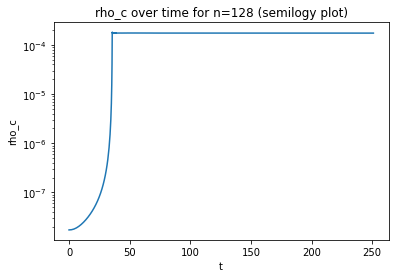

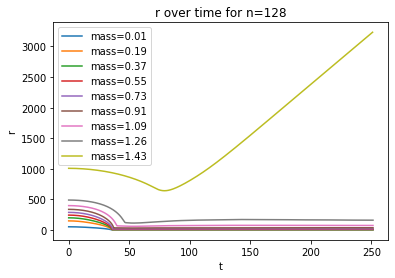

In [ ]:
# Constants
n = 128
gamma0 = 4./3.
gamma1 = 3.0
rho_nucl = 1.4e-4
final_time = 500

def make_piecewisepolytopic():
    """
    Create a Piecewise Polytropic Equation of State (EOS) instance.

    Returns:
    - PiecewisePolytropic: An instance of the PiecewisePolytropic EOS.
    """
    myEOS = PiecewisePolytropic(rho_nucl, gamma1, gamma0)
    # Alternative: myEOS = GammaLaw(61382, gamma0)
    return myEOS

def evolve_star():
    """
    Evolve a stellar model using hydrodynamic simulations.

    This function initializes the simulation parameters, creates an EOS, sets the initial conditions,
    evolves the star, and generates plots.

    Returns:
    - None: Displays plots of central density, radius, and radial profiles over time.
    """
    # Hardcode simulation specifics
    plots = False
    n_t = 16
    n_p = 20
    n_m = 25
    courant = 0.5
    R_est = 1010

    # Create EOS
    myEOS = make_piecewisepolytopic()

    # Create integrator
    myIntegrator = make_integrator(n, myEOS, courant, R_est, n_m, n_t, n_p, plots)
    myIntegrator.init_gridfunctions()

    # Set a new gamma0
    new_gamma0 = 1.3
    myIntegrator.set_gamma0(new_gamma0)

    # Integrate the star's evolution
    myIntegrator.integrate(final_time)
    myIntegrator.close_files()

# Uncomment the following line to run the simulation
# evolve_star()

# Generate and display plots
central_density_plot_one_n(n)
R_plot(n)
r_plots(n)

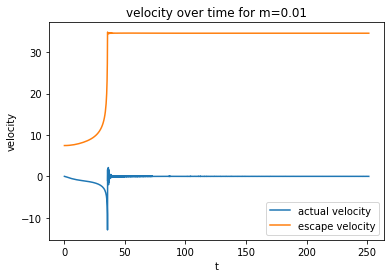

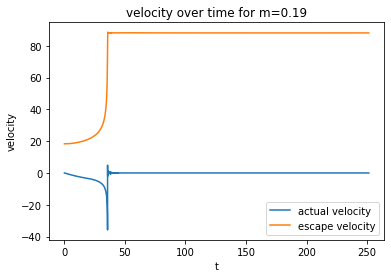

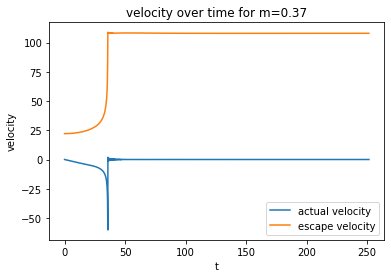

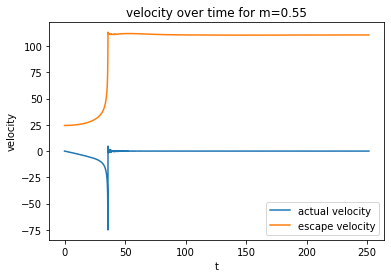

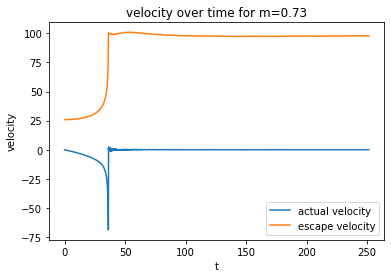

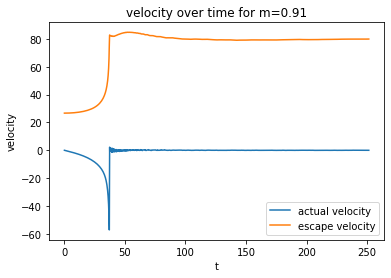

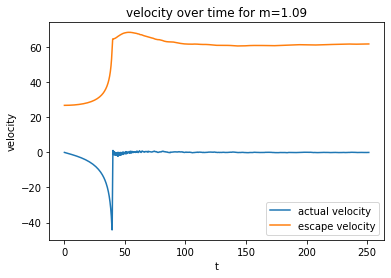

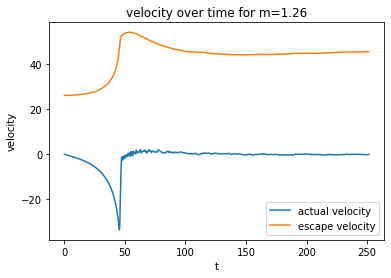

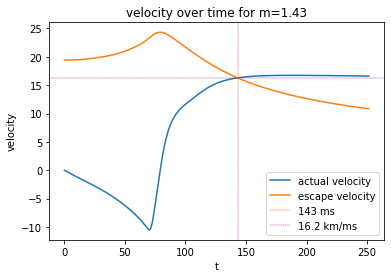

In [ ]:
n = 128
velocity_plots(n)